In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import warnings
import re
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.float_format', '{:,.4f}'.format)
pd.set_option('display.max_rows', 80)

df = pd.read_csv("car_age_0_updated_dataset.csv", low_memory=False)
print(f"Initial shape: {df.shape}")

counts = df['od_claim_count'].value_counts().sort_index()
print(counts)

df['policy_start_date'] = pd.to_datetime(df['policy_start_date'])
start_date = df['policy_start_date'].min()
end_date = df['policy_start_date'].max()

print(f"Start date: {start_date}")
print(f"End date:   {end_date}")

print("\n Data Types")
with pd.option_context('display.max_rows', None):
    df.info()

print("\n Missing Value Percentage (All Columns)")
missing_percent = (df.isnull().sum() / len(df)) * 100
with pd.option_context('display.max_rows', None):
    print(missing_percent.sort_values(ascending=False))

print("\n Numerical Feature Summary")
with pd.option_context('display.max_rows', None, 'display.float_format', '{:,.2f}'.format):
    print(df.describe(include='number').transpose())

Initial shape: (82994, 57)
od_claim_count
0.0000    61784
1.0000    15169
2.0000     4498
3.0000     1092
4.0000      315
5.0000       85
6.0000       31
7.0000       11
8.0000        6
9.0000        3
Name: count, dtype: int64
Start date: 2018-09-10 00:00:00
End date:   2025-09-30 00:00:00

 Data Types
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82994 entries, 0 to 82993
Data columns (total 57 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Unnamed: 0                  82994 non-null  int64         
 1   base_policy                 82994 non-null  object        
 2   od_claim_count              82994 non-null  float64       
 3   car_age                     82994 non-null  float64       
 4   experian_rank_final         77375 non-null  float64       
 5   quarterly_service           37 non-null     float64       
 6   pps_mapped                  81321 non-null  float64       
 7   norma

In [2]:
# 1. Preprocessing + Feature Engineering

# 1a. Drop columns
missing_percent = (df.isnull().sum() / len(df)) * 100
cols_mostly_empty = missing_percent[missing_percent > 70].index.tolist()
unique_counts = df.nunique()
cols_single_value = unique_counts[unique_counts == 1].index.tolist()

cols_to_drop = list(set(cols_mostly_empty + cols_single_value))

cols_to_drop.extend([
    'Unnamed: 0', 
    'policy_start_period', 
    'policy_start_year', 
    'user_agent', 
    'device_vendor_category',
    'base_policy',           
    'recommended_idv',
    'previous_policy_expired',
    'policy_start_month',
    'policy_created_on',
    'cc_group',
    'make',
    'customer_age_group',
    'exposure_calculated', 
    'variant_bracket',
    'customer_age_group_ordinal',
    'is_rsa',
    'intermediary_id', 
    'Status2',
    'Product_Type2',
    'variant_bracket_mapped',
    'hit_flag_service',
    'recommended_idv_grouped',
    'Product+Plan',
    'cc_group_ordinal',
    'transmission_type',
    'experian_rank_final',
    'model'
])

key_cols = ['od_claim_count', 'exposure', 'policy_start_date']
cols_to_drop = [col for col in cols_to_drop if col not in key_cols]

df_cleaned = df.drop(columns=cols_to_drop)
print(f"Shape after dropping columns: {df_cleaned.shape}")

# CLipping exposure between 0 and 1
df_cleaned['exposure'] = df_cleaned['exposure'].clip(0, 1)

# 1b. Sanitize Feature Names
original_cols = df_cleaned.columns.tolist()
sanitized_cols = [re.sub(r'[^A-Za-z0-9_]+', '_', col) for col in original_cols]
df_cleaned.columns = sanitized_cols

renamed_cols_dict = {orig: new for orig, new in zip(original_cols, sanitized_cols) if orig != new}
if renamed_cols_dict:
    print("Renamed columns:")
    for orig, new in renamed_cols_dict.items():
        print(f"  '{orig}'  =>  '{new}'")

# 1c. Handle date Column
DATE_COL_NAME = 'policy_start_date'
df_cleaned[DATE_COL_NAME] = pd.to_datetime(df_cleaned[DATE_COL_NAME])

# 1d. Define Feature, Target, and Weight
TARGET = 'od_claim_count'
WEIGHT = 'exposure'
DATE_COL = 'policy_start_date'
features = [col for col in df_cleaned.columns if col not in [TARGET, WEIGHT, DATE_COL]]

# 1e. Handle Categorical Features & NaNs
categorical_features = df_cleaned[features].select_dtypes(include=['object', 'category']).columns.tolist()

for col in categorical_features:
    df_cleaned[col] = df_cleaned[col].astype('category')

# 1f. Print Feature Lists
print(f"\nFinal Features for Model Training ({len(features)})")
numerical_features = df_cleaned[features].select_dtypes(include=np.number).columns.tolist()
print(f"\nNumerical Features ({len(numerical_features)}):")
for col in numerical_features:
    print(f"  - {col}")

print(f"\nCategorical Features ({len(categorical_features)}):")
for col in categorical_features:
    print(f"  - {col}")

# 1g. Feature Cardinality
print("\n Feature Cardinality")

cardinality = df_cleaned[features].nunique().sort_values(ascending=False)

print("Features with the most unique values:")
with pd.option_context('display.max_rows', 30):
    print(cardinality.head(30))

# Identify high-cardinality categorical features
high_card_cols = [
    col for col in categorical_features 
    if df_cleaned[col].nunique() > 50
]

print(f"Shape before filtering: {df_cleaned.shape}")

df_cleaned = df_cleaned[
    (df_cleaned['corrected_body_type'] != 'VAN') & 
    (df_cleaned['corrected_body_type'] != 'Pickup Truck') & 
    (df_cleaned['make_mapped'] != 'CHEVROLET') & 
    (df_cleaned['make_mapped'] != 'DATSUN') &
    (df_cleaned['make_mapped'] != 'FORD') & 
    (df_cleaned['make_mapped'] != 'TATA TO')
].copy()

if 'corrected_body_type' in df_cleaned.columns:
    df_cleaned['corrected_body_type'] = df_cleaned['corrected_body_type'].replace({'Coupe': 'SEDAN'})

cols_to_clean = ['corrected_body_type', 'make_mapped']

for col in cols_to_clean:
    if col in df_cleaned.columns and hasattr(df_cleaned[col], 'cat'):
        df_cleaned[col] = df_cleaned[col].cat.remove_unused_categories()

print(f"Shape after filtering: {df_cleaned.shape}")
print("\n Check Removed Categories (Should be empty or error)")
try:
    print(f"Vans remaining: {len(df_cleaned[df_cleaned['corrected_body_type'] == 'VAN'])}")
    print(f"Chevrolets remaining: {len(df_cleaned[df_cleaned['make_mapped'] == 'CHEVROLET'])}")
except:
    print("Categories successfully removed.")

print("\nNew Make Counts:")
print(df_cleaned['make_mapped'].value_counts().tail(10))

print("Max CC before fix:", df_cleaned['cc'].max())
print("Mean CC of EVs before fix:", df_cleaned[df_cleaned['fuel_type'] == 'electric']['cc'].mean())

df_cleaned.loc[df_cleaned['fuel_type'] == 'electric', 'cc'] = 0

cap_value = 6000 
outliers = df_cleaned[df_cleaned['cc'] > cap_value]
print(f"Capping {len(outliers)} non-EV outliers at {cap_value}cc.")
df_cleaned.loc[df_cleaned['cc'] > cap_value, 'cc'] = cap_value

print("Max CC after fix:", df_cleaned['cc'].max())

Shape after dropping columns: (82994, 12)

Final Features for Model Training (9)

Numerical Features (5):
  - personal_loan_flag
  - embedded_red_flag
  - ex_showroom_price
  - customer_age
  - cc

Categorical Features (4):
  - corrected_body_type
  - fuel_type
  - city_mapped
  - make_mapped

 Feature Cardinality
Features with the most unique values:
ex_showroom_price      5384
cc                      118
customer_age             63
make_mapped              19
city_mapped              11
corrected_body_type       6
fuel_type                 4
personal_loan_flag        2
embedded_red_flag         2
dtype: int64
Shape before filtering: (82994, 12)
Shape after filtering: (82371, 12)

 Check Removed Categories (Should be empty or error)
Vans remaining: 0
Chevrolets remaining: 0

New Make Counts:
make_mapped
HONDA         4289
MG            4038
SKODA         2632
RENAULT       2539
TOYOTA        2141
NISSAN        2103
VOLKSWAGEN    1719
OTHER          917
JEEP           140
FIAT         

In [3]:
from sklearn.model_selection import train_test_split
import numpy as np

DEV_START = '2022-01-01'
DEV_END = '2025-03-30'
OOT_START = '2025-04-01'
OOT_END = '2025-07-30'

# Define the OOT Set
oot_df = df_cleaned[
    (df_cleaned[DATE_COL] >= OOT_START) & 
    (df_cleaned[DATE_COL] <= OOT_END)
].copy()

# Define the Development Set
dev_df = df_cleaned[
    (df_cleaned[DATE_COL] >= DEV_START) & 
    (df_cleaned[DATE_COL] <= DEV_END)
].copy()

print("--- Data Definitions ---")
print(f"Development Set: {dev_df.shape}")
print(f"OOT Set: {oot_df.shape}")

# COMPOSITE STRATIFICATION (City + Claim Count)

dev_df['stratify_key'] = (
    dev_df['city_mapped'].astype(str) + "_" + 
    dev_df['od_claim_count'].astype(str)
)

key_counts = dev_df['stratify_key'].value_counts()
rare_keys = key_counts[key_counts < 2].index

dev_df.loc[dev_df['stratify_key'].isin(rare_keys), 'stratify_key'] = 'Other_Rare'

print(f"Stratification Key Created. Rare groups merged: {len(rare_keys)}")

train_df, test_df = train_test_split(
    dev_df,
    test_size=0.20,
    random_state=42,
    stratify=dev_df['stratify_key']
)

train_df.drop(columns=['stratify_key'], inplace=True)
test_df.drop(columns=['stratify_key'], inplace=True)
dev_df.drop(columns=['stratify_key'], inplace=True)

print("\n--- Final Split Verification ---")
print(f"Train Shape: {train_df.shape}")
print(f"Test Shape:  {test_df.shape}")

# Check Claim Rates are balanced
train_mean = train_df['od_claim_count'].mean()
test_mean = test_df['od_claim_count'].mean()
print(f"Train Claim Freq: {train_mean:.4f}")
print(f"Test Claim Freq:  {test_mean:.4f}")

--- Data Definitions ---
Development Set: (64024, 12)
OOT Set: (5362, 12)
Stratification Key Created. Rare groups merged: 14

--- Final Split Verification ---
Train Shape: (51219, 12)
Test Shape:  (12805, 12)
Train Claim Freq: 0.3887
Test Claim Freq:  0.3876


In [4]:
features = [
    'cc',
    'personal_loan_flag',
    'embedded_red_flag',
    'ex_showroom_price',
    'customer_age',
    'corrected_body_type',
    'fuel_type',
    'city_mapped',
    'make_mapped'
]

In [5]:
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from scipy.stats import randint, uniform

X_train, y_train, w_train = train_df[features], train_df[TARGET], train_df[WEIGHT]
X_test, y_test, w_test = test_df[features], test_df[TARGET], test_df[WEIGHT]
X_oot, y_oot, w_oot = oot_df[features], oot_df[TARGET], oot_df[WEIGHT]

# 1. Define Monotonic Constraints
monotone_constraints = [0] * len(features)
try:
    rank_idx = features.index('experian_rank_final')
    monotone_constraints[rank_idx] = 1 # Force risk to increase as rank increases
    print("Applied Monotonic Constraint to Experian Rank.")
except ValueError:
    print("Experian Rank not found in features, skipping constraint.")

# 2. Hyperparameter Search Space
param_dist = {
    'num_leaves': randint(30, 80), 
    'max_depth': randint(3, 8),
    'reg_alpha': uniform(0.1, 5.0),   
    'reg_lambda': uniform(0.1, 5.0),  
    'min_child_samples': randint(300, 600), 
    'subsample': uniform(0.6, 0.3),        
    'colsample_bytree': uniform(0.6, 0.3), 
    'learning_rate': uniform(0.01, 0.1)
}

# Initialize Model
lgbm = lgb.LGBMRegressor(
    objective='poisson',
    metric='poisson',
    n_estimators=5000, 
    n_jobs=-1,
    random_state=42,
    verbosity=-1,
    monotone_constraints=monotone_constraints
)

# 4. TimeSeries Validation - ensures validate on future of train set, not random rows
tscv = TimeSeriesSplit(n_splits=3)

print("Starting Hyperparameter Tuning...")

search = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_dist,
    n_iter=30,                           
    scoring='neg_mean_poisson_deviance', 
    cv=tscv,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Run Search
search.fit(
    X_train, 
    y_train, 
    sample_weight=w_train,
    eval_set=[(X_test, y_test)],
    eval_sample_weight=[w_test],
    callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=0)]
)

print(f"Best Score: {search.best_score_}")
print(f"Best Parameters: {search.best_params_}")

# Extract Best Model & Predict
final_model = search.best_estimator_

print("Generating predictions with optimized model...")
pred_train = final_model.predict(X_train)
pred_test = final_model.predict(X_test)
pred_oot = final_model.predict(X_oot)

Experian Rank not found in features, skipping constraint.
Starting Hyperparameter Tuning...
Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Score: -1.068258908139834
Best Parameters: {'colsample_bytree': 0.6039794883479599, 'learning_rate': 0.10422017556848527, 'max_depth': 4, 'min_child_samples': 564, 'num_leaves': 55, 'reg_alpha': 0.5883605700319193, 'reg_lambda': 3.5211651325607844, 'subsample': 0.7320457481218804}
Generating predictions with optimized model...


In [6]:
def create_decline_analysis(y_true, y_pred, exposure, set_name, fixed_bins=None):
    print(f"\n--- Decile Analysis: {set_name} Set ---")
    
    eval_df = pd.DataFrame({
        'actual_count': y_true,
        'predicted_model_output': y_pred,
        'exposure': exposure
    })
    
    # BINNING LOGIC
    if fixed_bins is None:
        # CASE 1: CALCULATE NEW BINS (Use for Test Set) - calculate the decile boundaries based on this dataset
        eval_df['decile'], bins = pd.qcut(
            eval_df['predicted_model_output'], 
            10, 
            labels=False, 
            retbins=True,
            duplicates='drop'
        )
        
        # Extend the edges to Infinity to handle future outliers
        bins[0] = -np.inf
        bins[-1] = np.inf
        
        print("(Generated new fixed thresholds from this dataset)")
        
    else:
        # CASE 2: APPLY FIXED BINS (Use for Train/OOT) - used pd.cut instead of qcut to enforce the specific boundaries
        eval_df['decile'] = pd.cut(
            eval_df['predicted_model_output'], 
            bins=fixed_bins, 
            labels=False,
            include_lowest=True
        )
        bins = fixed_bins # Keep using the passed bins
        print("(Applied fixed thresholds from Reference Set)")

    # STANDARD AGGREGATION
    total_exposure = eval_df['exposure'].sum()
    overall_actual_ir = eval_df['actual_count'].sum() / total_exposure
    overall_pred_ir = eval_df['predicted_model_output'].mean()
    
    decile_groups = eval_df.groupby('decile')
    
    summary = pd.DataFrame({
        'Policies': decile_groups.size(),
        'Total Exposure': decile_groups['exposure'].sum(),
        'Actual Claims': decile_groups['actual_count'].sum(),
        'Predicted IR': decile_groups['predicted_model_output'].mean()
    })
    
    summary['Actual IR'] = np.where(summary['Total Exposure'] > 0, 
                                    summary['Actual Claims'] / summary['Total Exposure'], 0)
    
    summary['Delta'] = np.where(summary['Actual IR'] > 0, 
                                (summary['Predicted IR'] / summary['Actual IR']) - 1, np.nan)

    # Format
    display_df = summary[['Policies', 'Actual IR', 'Predicted IR', 'Delta']].copy()
    display_df['Actual IR'] = (display_df['Actual IR'] * 100).map('{:,.2f}%'.format)
    display_df['Predicted IR'] = (display_df['Predicted IR'] * 100).map('{:,.2f}%'.format)
    display_df['Delta'] = (display_df['Delta'] * 100).map('{:,.2f}%'.format)
    
    print(display_df)
    
    return bins

# 1. Run TEST Set First (To Derive Thresholds) - capture 'test_bins' variable returned by function
test_bins = create_decline_analysis(y_test, pred_test, w_test, "Test (Reference)")

# Print the thresholds to confirm 
print("\nFixed Risk Thresholds (from Test):")
print(np.round(test_bins, 4))

# 2. Run TRAIN Set (Using Test Thresholds)
_ = create_decline_analysis(y_train, pred_train, w_train, "Train (Fixed Cuts)", fixed_bins=test_bins)

# 3. Run OOT Set (Using Test Thresholds)
_ = create_decline_analysis(y_oot, pred_oot, w_oot, "OOT (Fixed Cuts)", fixed_bins=test_bins)


--- Decile Analysis: Test (Reference) Set ---
(Generated new fixed thresholds from this dataset)
        Policies Actual IR Predicted IR   Delta
decile                                         
0           1281    24.25%       22.81%  -5.94%
1           1280    29.75%       28.08%  -5.62%
2           1281    31.62%       31.17%  -1.43%
3           1280    33.92%       33.64%  -0.81%
4           1281    36.70%       36.14%  -1.52%
5           1280    38.61%       38.74%   0.33%
6           1280    41.78%       41.84%   0.12%
7           1281    48.95%       45.72%  -6.61%
8           1280    52.21%       51.31%  -1.71%
9           1281    69.18%       64.91%  -6.17%

Fixed Risk Thresholds (from Test):
[  -inf 0.2637 0.2973 0.3244 0.3486 0.3738 0.4014 0.4358 0.4817 0.5529
    inf]

--- Decile Analysis: Train (Fixed Cuts) Set ---
(Applied fixed thresholds from Reference Set)
        Policies Actual IR Predicted IR    Delta
decile                                          
0           5029 

In [7]:
from IPython.display import display

def analyze_all_features(df, model, feature_list, target_col, weight_col, bins=10, discrete_vars=None):
    if discrete_vars is None:
        discrete_vars = []
        
    print(f"--- Starting One-Way Analysis on {len(feature_list)} Features ---\n")
    
    df_scored = df.copy()
    
    # Get Predictions
    valid_features = [f for f in feature_list if f in df_scored.columns]
    df_scored['pred_rate'] = model.predict(df_scored[valid_features])
    df_scored['pred_claims'] = df_scored['pred_rate'] * df_scored[weight_col]
    
    # Loop through each feature
    for col in valid_features:
        current_col_data = df_scored[col].copy()
        
        is_discrete_request = col in discrete_vars
        is_numeric = pd.api.types.is_numeric_dtype(current_col_data)
        
        if is_numeric and not is_discrete_request:
            try:
                binned = pd.qcut(current_col_data, bins, duplicates='drop')
            except ValueError:
                binned = pd.cut(current_col_data, bins)
            
            df_scored['bucket'] = binned.astype(str)
            df_scored.loc[current_col_data.isna(), 'bucket'] = 'Missing'
            
        else:
            current_col_string = current_col_data.astype(str)
            
            current_col_string.loc[current_col_data.isna()] = 'Missing'
            
            unique_vals = current_col_string.nunique()
            
            if unique_vals > 20 and not is_discrete_request:
                top_cats = current_col_string.value_counts().nlargest(19).index
                df_scored['bucket'] = np.where(
                    current_col_string.isin(top_cats) | (current_col_string == 'Missing'), 
                    current_col_string, 
                    'Other'
                )
            else:
                df_scored['bucket'] = current_col_string

        summary = df_scored.groupby('bucket', observed=True).agg({
            weight_col: 'sum',
            target_col: ['sum', 'count'],
            'pred_claims': 'sum'
        })
        
        summary.columns = ['Exposure', 'Actual_Claims', 'Policy_Count', 'Pred_Claims']
        
        summary['Actual_Freq'] = np.where(summary['Exposure'] > 0, summary['Actual_Claims'] / summary['Exposure'], 0)
        summary['Pred_Freq'] = np.where(summary['Exposure'] > 0, summary['Pred_Claims'] / summary['Exposure'], 0)
        summary['A/E_Ratio'] = np.where(summary['Pred_Freq'] > 0, summary['Actual_Freq'] / summary['Pred_Freq'], 0)
        
        summary = summary.sort_index()
        
        if is_discrete_request:
            summary.index = summary.index.astype(str).str.replace(r'\.0$', '', regex=True)

        if 'Missing' in summary.index:
            summary = pd.concat([summary.drop('Missing'), summary.loc[['Missing']]])

        format_dict = {
            'Exposure': '{:,.1f}', 'Actual_Claims': '{:,.0f}', 'Policy_Count': '{:,.0f}',
            'Pred_Freq': '{:.2%}', 'Actual_Freq': '{:.2%}', 'A/E_Ratio': '{:.2f}'
        }
        
        print(f"Variable: {col}")
        display(summary[['Policy_Count', 'Exposure', 'Actual_Claims', 'Actual_Freq', 'Pred_Freq', 'A/E_Ratio']] \
            .style.format(format_dict) \
            .background_gradient(subset=['A/E_Ratio'], cmap='RdYlGn_r', vmin=0.8, vmax=1.2) \
            .bar(subset=['Exposure'], color='#d65f5f'))
        print("\n" + "="*50 + "\n")

no_binning_list = [
    'embedded_red_flag', 
    'personal_loan_flag', 
    'experian_rank_final', 
    'policy_start_month'
]

analyze_all_features(oot_df, final_model, features, TARGET, WEIGHT, discrete_vars=no_binning_list)

--- Starting One-Way Analysis on 9 Features ---

Variable: cc


,Policy_Count,Exposure,Actual_Claims,Actual_Freq,Pred_Freq,A/E_Ratio
bucket,,,,,,
"(-0.001, 999.0]","2,041",681.4,342,50.19%,42.25%,1.19
"(1197.0, 1199.0]",965,328.8,128,38.92%,40.52%,0.96
"(1199.0, 1451.0]",46,14.9,1,6.71%,35.19%,0.19
"(1451.0, 1497.0]",885,292.1,124,42.44%,35.48%,1.20
"(1497.0, 1498.0]",226,74.2,30,40.44%,39.32%,1.03
"(1498.0, 6000.0]",479,157.8,37,23.44%,26.61%,0.88
"(999.0, 1197.0]",720,236.8,110,46.46%,42.10%,1.10




Variable: personal_loan_flag


,Policy_Count,Exposure,Actual_Claims,Actual_Freq,Pred_Freq,A/E_Ratio
bucket,,,,,,
0,"2,377",793.3,312,39.33%,36.78%,1.07
1,"2,587",859.2,408,47.49%,42.34%,1.12
Missing,398,133.6,52,38.92%,33.89%,1.15




Variable: embedded_red_flag


,Policy_Count,Exposure,Actual_Claims,Actual_Freq,Pred_Freq,A/E_Ratio
bucket,,,,,,
0,886,295.5,106,35.88%,38.07%,0.94
1,"2,017",681.0,356,52.28%,44.25%,1.18
Missing,"2,459",809.6,310,38.29%,35.46%,1.08




Variable: ex_showroom_price


,Policy_Count,Exposure,Actual_Claims,Actual_Freq,Pred_Freq,A/E_Ratio
bucket,,,,,,
"(1126000.0, 1279900.0]",548,190.9,79,41.38%,37.84%,1.09
"(1279900.0, 1440000.0]",541,180.3,81,44.94%,36.56%,1.23
"(1440000.0, 1595000.0]",525,176.6,96,54.35%,40.36%,1.35
"(1595000.0, 1899000.0]",547,175.5,71,40.45%,37.03%,1.09
"(1899000.0, 2529000.0]",534,175.4,54,30.79%,32.92%,0.94
"(2529000.0, 9250000.0]",522,169.0,104,61.53%,39.71%,1.55
"(412999.999, 787600.0]",541,179.7,71,39.52%,41.77%,0.95
"(787600.0, 895000.0]",542,180.9,73,40.36%,43.92%,0.92
"(895000.0, 999000.0]",539,182.8,71,38.84%,42.71%,0.91




Variable: customer_age


,Policy_Count,Exposure,Actual_Claims,Actual_Freq,Pred_Freq,A/E_Ratio
bucket,,,,,,
"(17.999, 28.0]",510,172.5,109,63.20%,55.11%,1.15
"(28.0, 31.0]",594,198.4,118,59.46%,45.44%,1.31
"(31.0, 33.0]",457,151.9,83,54.63%,43.00%,1.27
"(33.0, 35.0]",473,152.9,65,42.52%,38.88%,1.09
"(35.0, 38.0]",638,210.3,78,37.08%,38.05%,0.97
"(38.0, 40.0]",389,129.9,47,36.17%,36.83%,0.98
"(40.0, 43.0]",472,160.5,61,38.00%,33.81%,1.12
"(43.0, 47.0]",480,158.7,57,35.92%,33.40%,1.08
"(47.0, 54.0]",478,161.1,51,31.65%,34.84%,0.91




Variable: corrected_body_type


,Policy_Count,Exposure,Actual_Claims,Actual_Freq,Pred_Freq,A/E_Ratio
bucket,,,,,,
HATCHBACK,657,215.8,98,45.42%,46.30%,0.98
SEDAN,341,111.8,52,46.51%,48.81%,0.95
SUV,"3,910","1,307.4",571,43.68%,37.08%,1.18
Missing,454,151.1,51,33.76%,40.81%,0.83




Variable: fuel_type


,Policy_Count,Exposure,Actual_Claims,Actual_Freq,Pred_Freq,A/E_Ratio
bucket,,,,,,
diesel,542,181.2,58,32.01%,30.59%,1.05
electric,"1,208",391.6,221,56.44%,42.85%,1.32
internal_lpg_cng,390,129.9,68,52.33%,50.30%,1.04
petrol,"3,222","1,083.3",425,39.23%,38.06%,1.03




Variable: city_mapped


,Policy_Count,Exposure,Actual_Claims,Actual_Freq,Pred_Freq,A/E_Ratio
bucket,,,,,,
Bengaluru,"1,294",441.7,172,38.94%,36.15%,1.08
Chennai,255,84.9,48,56.54%,44.17%,1.28
Delhi | NCR,"1,072",353.2,134,37.94%,39.69%,0.96
Gujarat,130,44.3,30,67.71%,37.02%,1.83
High next16,260,86.5,43,49.72%,44.39%,1.12
Hyderabad,304,101.3,44,43.44%,41.09%,1.06
Kolkata,73,26.2,17,64.85%,55.03%,1.18
Low next16,215,71.3,24,33.66%,34.72%,0.97
Mumbai,349,110.4,48,43.47%,43.66%,1.00




Variable: make_mapped


,Policy_Count,Exposure,Actual_Claims,Actual_Freq,Pred_Freq,A/E_Ratio
bucket,,,,,,
HONDA,234,77.2,28,36.26%,40.87%,0.89
HYUNDAI,671,218.4,94,43.03%,38.61%,1.11
JEEP,1,0.3,0,0.00%,24.27%,0.00
KIA,447,153.7,59,38.39%,36.38%,1.06
MAHINDRA,"1,079",356.0,169,47.48%,32.88%,1.44
MARUTI,390,129.7,65,50.11%,42.83%,1.17
MG,393,133.5,72,53.95%,42.70%,1.26
NISSAN,87,28.1,13,46.33%,44.65%,1.04
OTHER,159,52.4,19,36.23%,43.57%,0.83


Plotting all 9 features...
Plot saved as shap_summary_plot.png


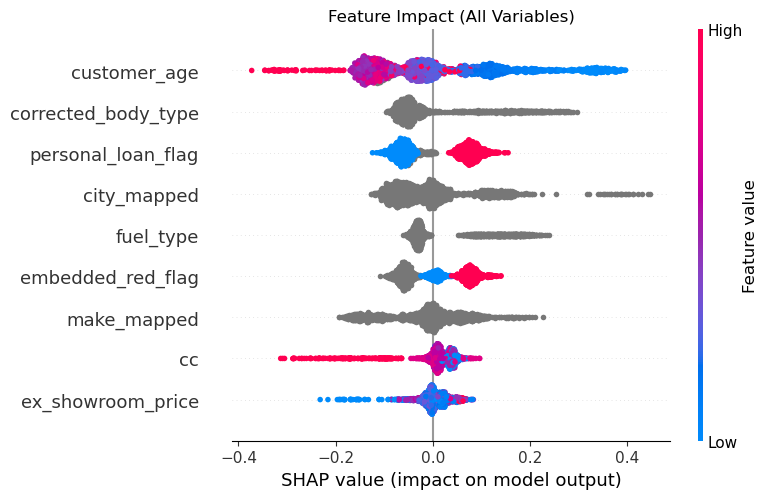

In [11]:
import shap
import matplotlib.pyplot as plt

# --- THE FIX: Initialize the explainer with your trained model ---
# Based on your code (Page 12), your best model is named 'final_model'
explainer = shap.TreeExplainer(final_model) 
# -----------------------------------------------------------------

# Calculate SHAP Values
sample_data = X_oot.sample(n=2000, random_state=42)
shap_values = explainer.shap_values(sample_data)

# Determine total number of features
total_features = sample_data.shape[1]

# Plot features
print(f"Plotting all {total_features} features...")
plt.figure(figsize=(12, 8 + (total_features * 0.4)))
shap.summary_plot(
    shap_values,
    sample_data,
    max_display=total_features,
    show=False
)
plt.title("Feature Impact (All Variables)")
plt.tight_layout()

plt.savefig("shap_summary_plot.png", dpi=300, bbox_inches='tight')
print("Plot saved as shap_summary_plot.png")

plt.show()

In [12]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_poisson_deviance, auc

# Define Helper Functions

def gini_coefficient(y_true, y_pred, sample_weight):
    df_temp = pd.DataFrame({
        'true': y_true,
        'pred': y_pred,
        'weight': sample_weight
    }).sort_values('pred', ascending=False) 

    # cumulative exposure share
    cum_exposure = np.cumsum(df_temp['weight']).to_numpy()
    total_exposure = cum_exposure[-1]
    if total_exposure <= 0:
        return np.nan
    cum_exposure = cum_exposure / total_exposure

    # cumulative claims share (counts)
    cum_claims = np.cumsum(df_temp['true']).to_numpy()
    total_claims = cum_claims[-1]
    if total_claims <= 0:
        return np.nan
    cum_claims = cum_claims / total_claims

    # add endpoints so AUC integrates the full curve
    x = np.r_[0.0, cum_exposure, 1.0]
    y = np.r_[0.0, cum_claims, 1.0]

    area = auc(x, y)
    return (2 * area) - 1 

def get_metrics(name, X, y, w, model):
    # 1. Generate Predictions
    pred_rate = model.predict(X)
    
    # 2. Calculate Aggregates
    policies = len(X)
    total_exposure = w.sum()
    total_claims = y.sum()
    
    actual_ir = total_claims / total_exposure
    
    # Predicted IR (Weighted Average)
    # Sum of expected claims / Total Exposure
    predicted_claims = pred_rate * w
    predicted_ir = predicted_claims.sum() / total_exposure
    
    # 3. Model Metrics
    deviance = mean_poisson_deviance(y, pred_rate, sample_weight=w)
    
    # Gini Index (Higher is better)
    gini = gini_coefficient(y, pred_rate, w)
    
    return {
        "Dataset": name,
        "# of Policies": policies,
        "Total Exposure": total_exposure,
        "# of Claims": total_claims,
        "Actual IR": actual_ir,
        "Predicted IR": predicted_ir,
        "Poisson Dev.": deviance,
        "Gini Index": gini
    }

# --- 2. Calculate for All Sets ---
model_features = features 

metrics_data = [
    get_metrics("Training Set", train_df[model_features], train_df[TARGET], train_df[WEIGHT], final_model),
    get_metrics("Test Set", test_df[model_features], test_df[TARGET], test_df[WEIGHT], final_model),
    get_metrics("OOT Set", oot_df[model_features], oot_df[TARGET], oot_df[WEIGHT], final_model)
]

#Format and Display

summary_table = pd.DataFrame(metrics_data).set_index("Dataset")

format_dict = {
    '# of Policies': '{:,.0f}',
    'Total Exposure': '{:,.1f}',
    '# of Claims': '{:,.0f}',
    'Actual IR': '{:.2%}',
    'Predicted IR': '{:.2%}',
    'Poisson Dev.': '{:.4f}',
    'Gini Index': '{:.4f}'
}

print("--- Model Performance Summary ---")
display(summary_table.style.format(format_dict))

--- Model Performance Summary ---


,# of Policies,Total Exposure,# of Claims,Actual IR,Predicted IR,Poisson Dev.,Gini Index
Dataset,,,,,,,
Training Set,"51,219","48,786.3","19,910",40.81%,39.55%,1.0495,-0.1967
Test Set,"12,805","12,183.3","4,963",40.74%,39.47%,1.0563,-0.1680
OOT Set,"5,362","1,786.0",772,43.22%,39.24%,0.8190,-0.1978
